# Set up

In [1]:
import joblib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from config import sqlURL
from imblearn.combine import SMOTEENN
from sqlalchemy import create_engine, inspect, text
from sqlalchemy.exc import ProgrammingError, SQLAlchemyError
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc

# Load and Store Data in SQL

In [2]:
# Load dataset
df = pd.read_csv("resources/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print(len(df))

284807


In [4]:
# Connect to SQL database
engine = create_engine(sqlURL)

# Store dataframe in SQL table
df.to_sql('transactions', engine, if_exists='replace', index=False)

807

In [5]:
try:
    # Add an `id` column as a primary key with auto-increment
    with engine.connect() as conn:
        conn.execute("ALTER TABLE transactions ADD COLUMN id SERIAL PRIMARY KEY;")
        conn.commit()

    # Store dataframe in SQL table
    df.to_sql('transactions', engine, if_exists='replace', index=False)
except Exception:
    pass


# Query Data from SQL for Analysis

In [6]:
# Read from SQL database
query = "SELECT * FROM transactions"
df = pd.read_sql(query, engine)

# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,id
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,2
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,3
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,5


# Data Processing

## Class Imbalance

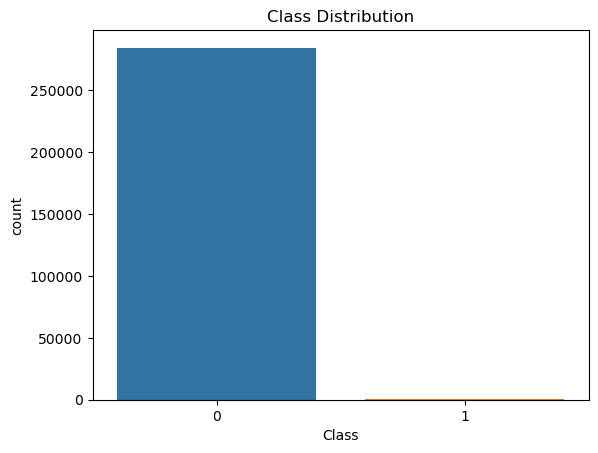

In [8]:
# Count fraud vs non-fraud transactions
sns.countplot(x=df['Class'])
plt.title("Class Distribution")
plt.show()

In [9]:
# Calculate total number of transactions
total_transactions = len(df)

# Calculate counts for each class
fraudulent_count = df[df['Class'] == 1].shape[0]
non_fraudulent_count = df[df['Class'] == 0].shape[0]

# Calculate percentages
fraudulent_percentage = (fraudulent_count / total_transactions) * 100
non_fraudulent_percentage = (non_fraudulent_count / total_transactions) * 100

# Print results
print(f"Fraudulent Transactions: {fraudulent_percentage:.2f}%")
print(f"Non-Fraudulent Transactions: {non_fraudulent_percentage:.2f}%")


Fraudulent Transactions: 0.17%
Non-Fraudulent Transactions: 99.83%


## Normalize Amount

In [10]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

## Split Data for Training

In [11]:
# Define features and target variable
X = df.drop(columns=['Class'])
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Train ML Model

## Handling Class Imbalance (SMOTE)

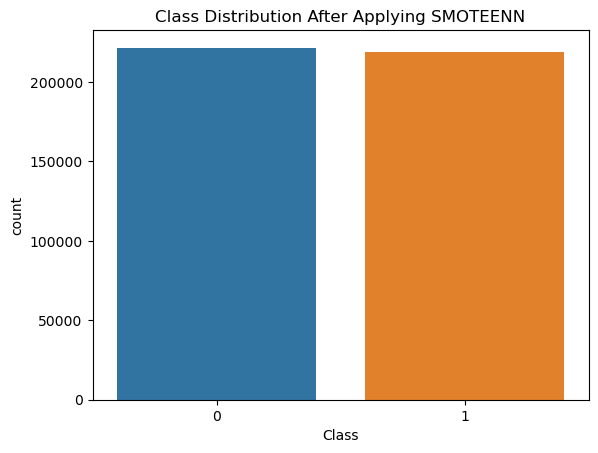

In [12]:
# Initialize SMOTEENN
smote_enn = SMOTEENN(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Verify the new class distribution
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After Applying SMOTEENN")
plt.show()

## Random Forest Model

In [13]:
# Initialize the RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

# Evaluation of Performance (AUPRC)

Precision-Recall AUC: 0.8547


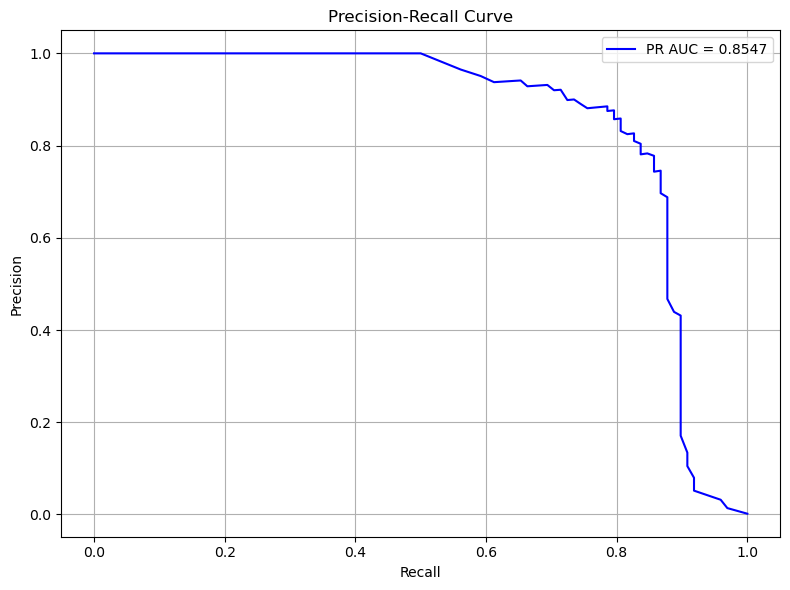

In [14]:
# Assuming y_test are the true labels and y_scores are the predicted probabilities for the positive class
# If not already available, we'll use model.predict_proba to generate scores
# For this example, assume y_s

# Generate the scores using the model (recompute just in case)
y_scores = model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Calculate area under the precision-recall curve
pr_auc = auc(recall, precision)

print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot as an image file
plt.savefig("resources/images/precision_recall_curve.png", dpi=300)

plt.show()

In [15]:
# Save the fitted scaler
joblib.dump(scaler, 'scaler.pkl')

# Make predictions on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Generate classification report
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC Score: {auc_roc:.4f}")

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.84      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC Score: 0.9801
Precision-Recall AUC: 0.8547


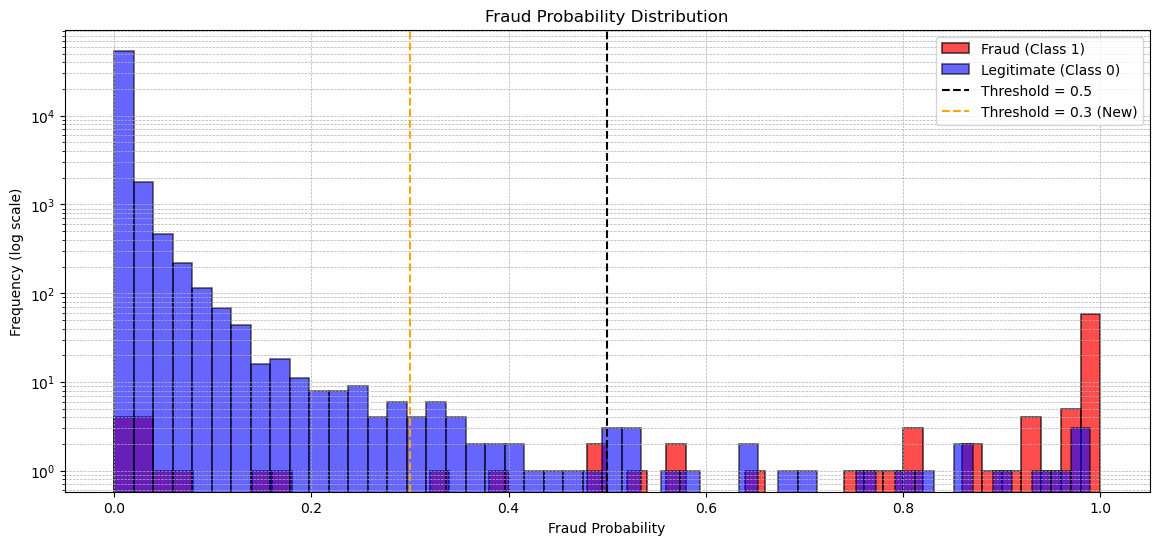

In [16]:
# Get fraud probabilities on test set
fraud_probs = model.predict_proba(X_test)[:, 1]

# Plot histogram with better visibility for fraud cases
plt.figure(figsize=(14, 6))  # Larger figure size
plt.hist(fraud_probs[y_test == 1], bins=50, alpha=0.7, label="Fraud (Class 1)", color='red', edgecolor='black', linewidth=1.2)
plt.hist(fraud_probs[y_test == 0], bins=50, alpha=0.6, label="Legitimate (Class 0)", color='blue', edgecolor='black', linewidth=1.2)

# Apply log scale to Y-axis for better fraud visibility
plt.yscale('log')  

# Vertical lines for probability thresholds
plt.axvline(x=0.5, color='black', linestyle='dashed', label="Threshold = 0.5")
plt.axvline(x=0.3, color='orange', linestyle='dashed', label="Threshold = 0.3 (New)")

# Labels and title
plt.xlabel("Fraud Probability")
plt.ylabel("Frequency (log scale)")
plt.title("Fraud Probability Distribution")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for better readability
plt.show()


# Save and Deploy Model

In [17]:
# Save model
joblib.dump(model, "fraud_detection_model.pkl")

['fraud_detection_model.pkl']

In [18]:
# Load model
model = joblib.load("fraud_detection_model.pkl")

# Model Testing

In [19]:
testID = 4921  # Example transaction ID
scaler_path = 'scaler.pkl'  # Update with the actual path to your scaler file

def varify_results(testID):
    query = f"SELECT \"Class\", \"id\" FROM transactions WHERE id = {testID}"
    transaction = pd.read_sql(query, engine)

    if not transaction.empty:
        return 1 if transaction.iloc[0]["Class"] == 1 else 0
    else:
        return "No transaction found"

def check_fraud(transaction_id, model, engine, scaler_path, threshold=0.5):
    """
    Predicts whether a transaction is fraudulent or legitimate based on its ID.

    Parameters:
    - transaction_id (int): The ID of the transaction to be evaluated.
    - model: The trained machine learning model.
    - engine: SQLAlchemy engine for database connection.
    - scaler_path (str): Path to the saved StandardScaler instance.
    - threshold (float): The probability threshold for classifying a transaction as fraudulent.

    Returns:
    - str: 'Fraudulent' if the transaction is predicted as fraud, otherwise 'Legitimate'.
    """
    # Load the fitted scaler
    scaler = joblib.load(scaler_path)

    # Query the transaction by ID
    query = f"SELECT * FROM transactions WHERE id = {transaction_id}"
    transaction = pd.read_sql(query, engine)

    if transaction.empty:
        return "Transaction not found."

    # Preprocess the transaction data
    transaction_features = transaction.drop(columns=['Class'])
    transaction_features['Amount'] = scaler.transform(transaction_features[['Amount']])

    # Predict the probability of fraud
    fraud_probability = model.predict_proba(transaction_features)[:, 1][0]

    # Determine the classification based on the threshold
    return 1 if fraud_probability >= threshold else 0
    
print("Prediction: " + str(check_fraud(testID, model, engine, scaler_path, threshold=0.3)))
print("Expected result: " + str(varify_results(testID))) 

Prediction: 1
Expected result: 1
